===Portfolio: Vanguard Canadian===
From 2015-06-19 to 2021-05-01

Initial Investment         = $100,000.00
Total S&P 500 Benchmark    = $198,160.65 = +98,160.65$ = +98.16% (total) = +11.71% (annualized)
Total Portfolio            = $125,215.68 = +25,215.68$ = +25.22% (total) =  +3.84% (annualized)
Total Portfolio Rebalanced = $125,323.33 = +25,323.33$ = +25.32% (total) =  +3.85% (annualized)
Holdings:
                      Book           Percent       Current           Annualized Rebalanced           Annualized
    Holding          Value   #Shares Portfolio       Value   #Shares Return%        Yearly   #Shares Return%
    VGRO.TO     80,000.00$    3277.3  80.0%     99,172.47$    3277.3   3.7%     99,973.30$    3303.8   3.8%
    XGRO.TO     10,000.00$     527.7  10.0%     12,828.50$     527.7   4.3%     12,510.44$     514.6   3.8%
    VEQT.TO     10,000.00$     395.4  10.0%     13,214.71$     395.4   4.8%     12,839.59$     384.2   4.3%




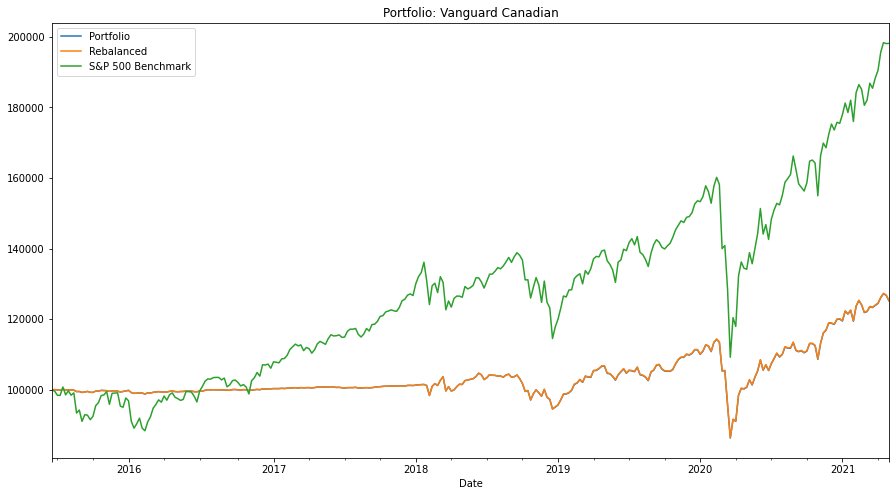




===Portfolio: Tech Stocks===
From 2015-06-19 to 2021-05-01

Initial Investment         = $100,000.00
Total S&P 500 Benchmark    = $198,160.65 = +98,160.65$ = +98.16% (total) = +11.71% (annualized)
Total Portfolio            = $469,729.37 = +369,729.37$ = +369.73% (total) = +26.65% (annualized)
Total Portfolio Rebalanced = $467,626.10 = +367,626.10$ = +367.63% (total) = +26.57% (annualized)
Holdings:
                      Book           Percent       Current           Annualized Rebalanced           Annualized
    Holding          Value   #Shares Portfolio       Value   #Shares Return%        Yearly   #Shares Return%
       AAPL     20,000.00$     631.9  20.0%     83,071.10$     631.9  24.5%     86,100.66$     655.0  25.1%
       AMZN     20,000.00$      46.0  20.0%    159,450.92$      46.0  35.9%     92,522.86$      26.7  26.4%
       NFLX     20,000.00$     213.1  20.0%    109,398.56$     213.1  29.3%     82,525.02$     160.7  24.4%
         FB     20,000.00$     242.4  20.0%     7

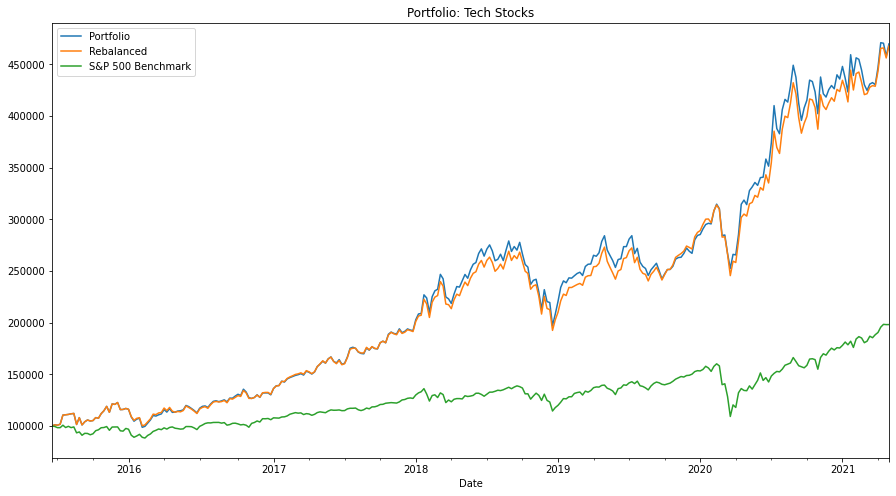




===Portfolio: Nasdaq QQQ===
From 2015-06-19 to 2021-05-01

Initial Investment         = $100,000.00
Total S&P 500 Benchmark    = $198,160.65 = +98,160.65$ = +98.16% (total) = +11.71% (annualized)
Total Portfolio            = $307,571.20 = +207,571.20$ = +207.57% (total) = +19.29% (annualized)
Total Portfolio Rebalanced = $307,571.20 = +207,571.20$ = +207.57% (total) = +19.29% (annualized)
Holdings:
                      Book           Percent       Current           Annualized Rebalanced           Annualized
    Holding          Value   #Shares Portfolio       Value   #Shares Return%        Yearly   #Shares Return%
        QQQ    100,000.00$     910.0 100.0%    307,571.20$     910.0  19.3%    307,571.20$     910.0  19.3%




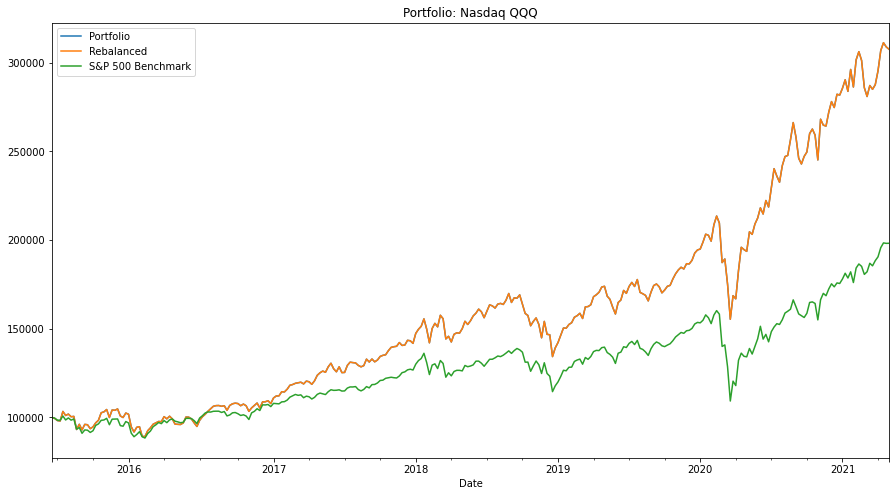




===Portfolio: BillG===
From 2015-06-19 to 2021-05-01

Initial Investment         = $100,000.00
Total S&P 500 Benchmark    = $198,160.65 = +98,160.65$ = +98.16% (total) = +11.71% (annualized)
Total Portfolio            = $278,266.44 = +178,266.44$ = +178.27% (total) = +17.56% (annualized)
Total Portfolio Rebalanced = $260,056.50 = +160,056.50$ = +160.06% (total) = +16.39% (annualized)
Holdings:
                      Book           Percent       Current           Annualized Rebalanced           Annualized
    Holding          Value   #Shares Portfolio       Value   #Shares Return%        Yearly   #Shares Return%
       AAPL      8,972.07$     283.5   9.0%     37,266.00$     283.5  24.5%     19,571.20$     148.9  13.4%
       MSFT      7,268.77$     157.7   7.3%     39,762.20$     157.7  29.3%     18,145.40$      72.0  15.7%
       INTC      6,498.54$     202.6   6.5%     11,657.65$     202.6  10.0%     16,522.48$     287.2  16.0%
       AMAT      5,292.58$     268.4   5.3%     35,617.

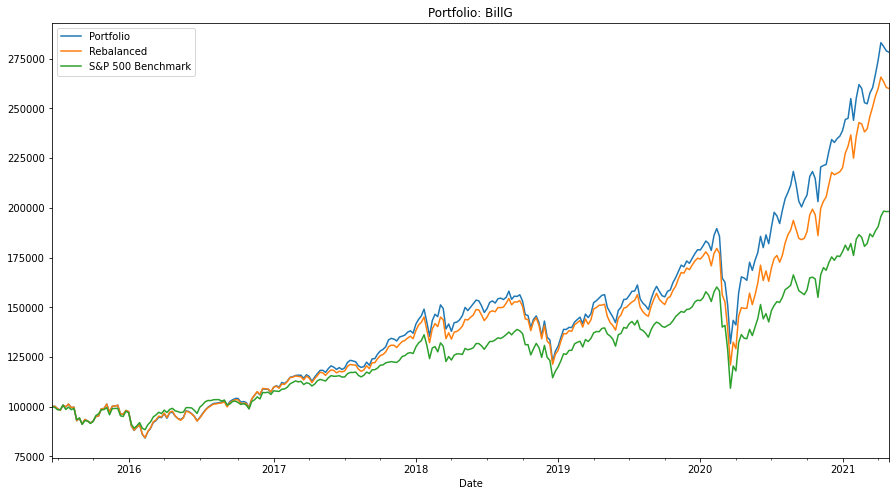

In [1]:
%config IPCompleter.greedy=True
#import backtest
from backtest import Holding, download_portfolio_history, rebalance_portfolio, plot_results
import datetime


# Dollars initially invested
initial_investment = 100000
# USD to CAD exchange rate
usd_cad = 1.3

# Collect data for this time period
start = datetime.datetime(2015,  6, 19)
end   = datetime.datetime(2021,  5,  1)

# Baseline benchmark
benchmark_portfolio = {
    'name': 'S&P 500 Benchmark',
    'holdings': [Holding('^GSPC', 100, 'S&P 500')]
}
benchmark_data, benchmark_num_shares = download_portfolio_history(benchmark_portfolio, start, end, initial_investment, usd_cad)

# Portfolio: Ticker, percentage of holdings, description
portfolios = [
    {
        'name': 'Vanguard Canadian',
        'holdings': [
            Holding('VGRO.TO', 80, 'Vanguard Growth ETF Portfolio (CAD)'),
            Holding('XGRO.TO', 10, 'iShares Core Growth ETF Portfolio (CAD)'),
            Holding('VEQT.TO', 10, 'Vanguard All-Equity ETF Portfolio (CAD)'),
        ]
    },
    {
        'name': 'Tech Stocks',
        'holdings': [
            Holding('AAPL', 20, ''),
            Holding('AMZN', 20, ''),
            Holding('NFLX', 20, ''),
            Holding('FB',   20, ''),
            Holding('BRK-B', 20, '')]
    },
    {
        'name': 'Nasdaq QQQ',
        'holdings': [
            Holding('QQQ', 100, ''),
        ]
    },
    {
        # See: https://www.holdingschannel.com/13f/cascade-investment-advisors-inc-top-holdings/
        'name': 'BillG',
        'holdings': [
            Holding('AAPL', 4077, ''),
            Holding('MSFT', 3303, ''),
            Holding('INTC', 2953, ''),
            Holding('AMAT', 2405, ''),
            Holding('FDX',  2217, ''),
            Holding('FFIV', 2096, ''),
            Holding('DIS',  2036, ''),
            Holding('NTR',  1999, ''),
            Holding('TGT',  1993, ''),
            Holding('WSM',  1989, ''),
            Holding('USB',  1979, ''),
            Holding('AMGN', 1961, ''),
            Holding('FB',   1906, ''),
            Holding('AMZN', 1872, ''),
            Holding('SCHW', 1863, ''),
            Holding('NVS',  1850, ''),
            Holding('EMR',  1817, ''),
            Holding('INFY', 1790, ''),
            Holding('RJF',  1790, ''),
            Holding('MET',  1788, ''),
            Holding('JLL',  1757, ''),
        ]
    },
]

for portfolio in portfolios:
    portfolio_data, portfolio_num_shares = download_portfolio_history(portfolio, start, end, initial_investment, usd_cad)
    rebalanced_num_shares = rebalance_portfolio(portfolio, portfolio_data, portfolio_num_shares, start, end)

    plot_results(portfolio, portfolio_data, portfolio_num_shares, rebalanced_num_shares, benchmark_portfolio, benchmark_data, benchmark_num_shares, start, end, initial_investment)
